## Import

In [1]:
from pathlib import Path
import random
import glob

import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, VGG19
import tensorflow_addons as tfa

pd.set_option('max_colwidth', None)

In [7]:
cd /home/sanjyot/latcom

/home/sanjyot/latcom


In [8]:
from label_preprocess import preprocess_labels

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
data_dir = Path('.').resolve() / 'dataset' / 'udacity_simulator' / 'tracks'
label_path = data_dir / 'driving_log.csv'

In [11]:
img_dir = data_dir / 'IMG'
img_count = len(list(img_dir.glob('*')))

lbl = pd.read_csv(label_path, names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

print(f'Total images: {img_count}')
print(f'Total records: {len(lbl)}')

Total images: 97329
Total records: 32443


## Preprocess labels

In [12]:
downsample_ratio = 0.9  # Controls how much percentage of straight driving labels are discarded

lbl_fix = preprocess_labels(lbl, downsample_ratio)


Original size: 32443 | New size: 14245
Size reduced to 43.91%


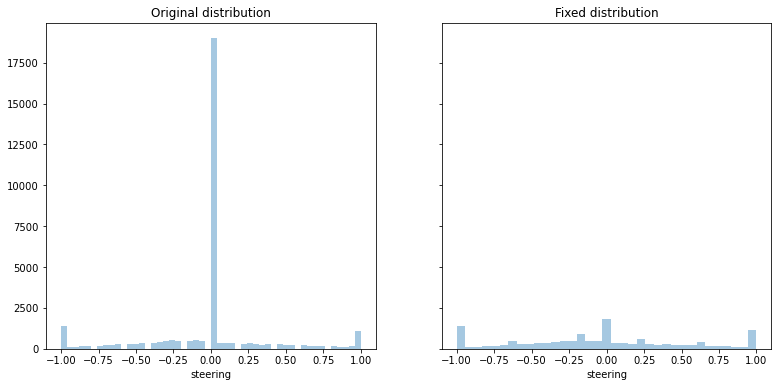

In [13]:
# Plot distribution change

fig, ax = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
sns.distplot(lbl['steering'], ax=ax[0], kde=False)
sns.distplot(lbl_fix['steering'], ax=ax[1], kde=False)
ax[0].set_title('Original distribution')
ax[1].set_title('Fixed distribution')
_ = plt.plot()

## Preprocess images

(160, 320, 3)


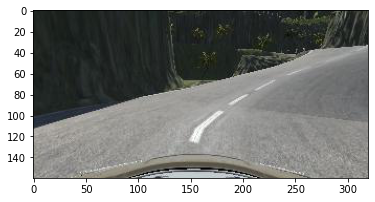

In [14]:
# Show sample image
index = 150
image_dir = data_dir / 'IMG'
sample_image_path = glob.glob(f'{str(image_dir)}/center*.jpg')[index]

img = cv.imread(sample_image_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
print(img.shape)
_ = plt.imshow(img)

In [15]:
def preprocess_image(img_path):
    """ Return preprocessed image tensor """

    height, width = 160, 320
    crop_window = tf.constant([60, 0, 75, width], dtype=tf.int32)
    final_image_shape = (100, 100)
    
    img = tf.io.read_file(img_path)  # Read
    img = tf.io.decode_and_crop_jpeg(img, crop_window=crop_window)  # Decode and crop
    img = tfa.image.gaussian_filter2d(img, filter_shape=(3, 3))  # Blur
    img = tf.image.resize(img, size=final_image_shape)  # Resize
    img = tf.divide(img, tf.constant(255.0))  # Normalize
    img = tf.image.rgb_to_yuv(img)  # Convert to YUV space
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


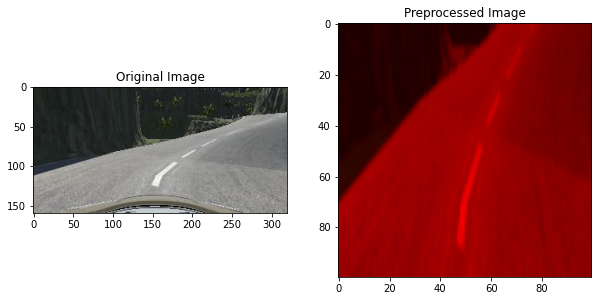

In [18]:
# Plot preprocessing result
original_image = cv.cvtColor(cv.imread(str(sample_image_path)), cv.COLOR_BGR2RGB)
preprocessed_image = preprocess_image(sample_image_path).numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')
_ = plt.plot()

## Prepare training data

In [19]:
batch_size = 128

In [25]:
X_paths = list(str(data_dir / 'IMG') + '/' + lbl_fix['center'])  # Center image paths
y = lbl_fix['steering'].values  # Corresponding steering angles

X_paths = tf.data.Dataset.from_tensor_slices(X_paths)
y = tf.data.Dataset.from_tensor_slices(y)

# Add preprocessing to pipeline
X = X_paths.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

tfdata = tf.data.Dataset.zip((X, y))
tfdata = tfdata.prefetch(tf.data.experimental.AUTOTUNE)  # Parallelize data processing and training
tfdata.element_spec

(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float64, name=None))

In [26]:
validation_split_ratio = 0.2

In [27]:
dataset_size = len(X_paths)

validation_count = int(validation_split_ratio * dataset_size)
training_count = dataset_size - validation_count

valid = tfdata.take(validation_count).batch(batch_size)
train = tfdata.skip(validation_count).batch(batch_size)

print(f'Training samples: {training_count}\nValidation samples: {validation_count}')

Training samples: 11396
Validation samples: 2849


## Resnet + Dense model

In [85]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [86]:
# Make last 4 ResNet-50 layers trainable
resnet.trainable = False

for x in resnet.layers[-4:]:
    x.trainable = True
    print(f'Layer: {x.name} | Parameters: {x.count_params()}')

Layer: conv5_block3_3_conv | Parameters: 1050624
Layer: conv5_block3_3_bn | Parameters: 8192
Layer: conv5_block3_add | Parameters: 0
Layer: conv5_block3_out | Parameters: 0


In [87]:
model = tf.keras.Sequential([
    resnet,
    layers.Dropout(0.5),
    layers.Flatten(),
    
    layers.Dense(100, activation='elu'),
    layers.Dropout(0.5),
    
    layers.Dense(50, activation='elu'),
    layers.Dropout(0.5),
    
    layers.Dense(10, activation='elu'),
    layers.Dropout(0.5),
    
    layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mse']
)

In [88]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dropout_16 (Dropout)         (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               3276900   
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)               

## NVIDIA model

In [85]:
nvidia = tf.keras.Sequential([
    layers.Conv2D(24, 5, 2, padding='same', input_shape=(100, 100, 3), activation='relu'),
    layers.Conv2D(36, 5, 2, padding='same', activation='relu'),
    layers.Conv2D(48, 5, 2, padding='same', activation='relu'),
    layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
    layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='tanh')
])

nvidia.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mse']
)

nvidia.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 50, 50, 24)        1824      
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 25, 25, 36)        21636     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 13, 13, 48)        43248     
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 7, 7, 64)          27712     
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)             

## Training

In [86]:
with tf.device('/GPU:0'):
    history = nvidia.fit(train, epochs=10, validation_data=valid)

Epoch 1/10
90/90 [==============================] - 42s 468ms/step - loss: 0.2069 - mse: 0.2069 - val_loss: 0.1818 - val_mse: 0.1818
Epoch 2/10
90/90 [==============================] - 20s 220ms/step - loss: 0.1373 - mse: 0.1373 - val_loss: 0.1307 - val_mse: 0.1307
Epoch 3/10
90/90 [==============================] - 22s 240ms/step - loss: 0.1169 - mse: 0.1169 - val_loss: 0.1249 - val_mse: 0.1249
Epoch 4/10
90/90 [==============================] - 21s 237ms/step - loss: 0.1081 - mse: 0.1081 - val_loss: 0.1081 - val_mse: 0.1081
Epoch 5/10
90/90 [==============================] - 22s 239ms/step - loss: 0.1014 - mse: 0.1014 - val_loss: 0.1011 - val_mse: 0.1011
Epoch 6/10
90/90 [==============================] - 21s 237ms/step - loss: 0.0949 - mse: 0.0949 - val_loss: 0.0997 - val_mse: 0.0997
Epoch 7/10
90/90 [==============================] - 21s 238ms/step - loss: 0.0919 - mse: 0.0919 - val_loss: 0.0959 - val_mse: 0.0959
Epoch 8/10
90/90 [==============================] - 21s 237ms/step - 

### MSE on models tried
ResNet + Dense model ~ 0.3

NVIDIA ~ 0.1

NVIDIA + tanh on last Dense ~ 0.1

In [87]:
# Set baseline mse as the mse of a model whose prediction is the mean y value

sse = 0
count = 0
iteration = 0
for valid_batch, train_batch in zip(valid.take(-1), train.take(-1)):
    y_valid = valid_batch[-1].numpy()
    y_train = train_batch[-1].numpy()
    
    iteration += 1
    count += len(y_valid)
    sse += np.sum((y_valid - y_train.mean())**2)
    
print(f'Mean predictor model MSE: {sse/count}')

Mean predictor model MSE: 0.3074810677407616


In [88]:
mean_steering = sse/count

In [89]:
h = (
    pd.DataFrame(history.history)
    .reset_index()
    .rename(columns={'index': 'epoch', 'mse': 'train_mse'})
    .melt(
        id_vars='epoch',
        value_vars=['train_mse', 'val_mse'],
        var_name='type'   
    )
)

In [90]:
h.tail()

,epoch,type,value
15,5,val_mse,0.099709
16,6,val_mse,0.095947
17,7,val_mse,0.094121
18,8,val_mse,0.098719
19,9,val_mse,0.095235


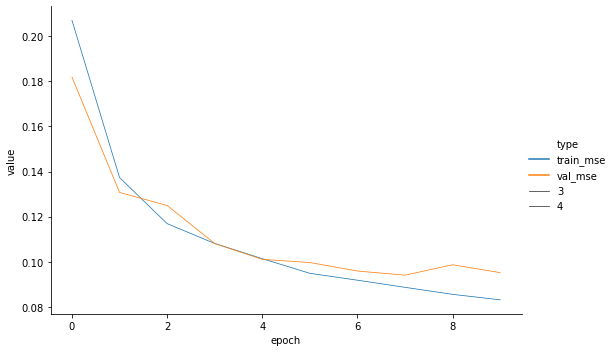

In [91]:
g = sns.relplot(x='epoch', y='value', hue='type', kind='line', data=h, aspect=1.5, size=4)
# g.ax.set_ylim(0, 2)

## Check predictions

In [94]:
y_pred = nvidia.predict(valid)

[]

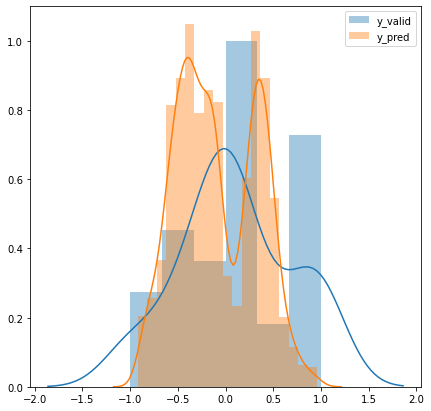

In [95]:
# Histogram of output distribution
# fig, ax = plt.subplots(figsize=(7, 7))
g = sns.distplot(y_valid, label='y_valid', ax=ax)
sns.distplot(y_pred, label='y_pred', ax=ax)
plt.legend()
plt.plot()

Better than the original ResNet + Dense model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean steering: 0.3074810677407616
Model steering: 0.685188889503479
Original steering: 0.7500001999999999


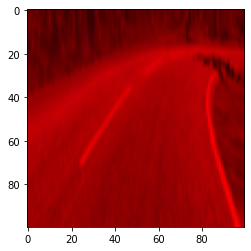

In [83]:
valid_batch = next(iter(valid))
pred_on_batch = nvidia.predict(valid_batch[0])

X_valid, y_valid = valid_batch[0].numpy(), valid_batch[1].numpy()

random_record = random.randint(0, batch_size - 1)
plt.imshow(X_valid[random_record])
print(f'Mean steering: {mean_steering}')
print(f'Model steering: {np.squeeze(pred_on_batch[random_record])}')
print(f'Original steering: {y_valid[random_record]}')

Much improvement from the ResNet model, can work with this for now.

## To check

1. Add tanh in final dense layer and check results